### The Mechanics of $n$-Player Differential Games
[This paper](https://arxiv.org/pdf/1802.05642.pdf) gives a general view of multiple players games and solutions using gradient-based methods. Motivated by the case that traditional gradient descent could fail in some cases, the paper argues that the gradient descent on the Hamiltonian converges to the Nash equilibrium

Setting: Let us consider $n$ players. Each of them has a (twice differentiable) loss $\ell_i(\mathbf{w}_i)$. The simultaeneous gradient is denoted argues
$$\xi(\mathbf{w}) = (\nabla_{\mathbf{w}_1}\ell_1, \dots, \nabla_{\mathbf{w}_n}\ell_n)$$
A typical example:
$$\ell_1(\mathbf{x}, \mathbf{y}) = \mathbf{x}^\top \mathbf{A}\mathbf{y} , \quad \ell_2(\mathbf{x}, \mathbf{y}) = -\mathbf{x}^\top \mathbf{A}\mathbf{y}$$
when considering SVD of $\mathbf{A} = \mathbf{U}\mathbf{D}\mathbf{V}^\top$ and changing the basis with $\mathbf{u} = \mathbf{D}^{\frac{1}{2}}\mathbf{U}\mathbf{x}$ and $\mathbf{v} = \mathbf{D}^{\frac{1}{2}}\mathbf{V}\mathbf{y}$, one key important quantitity called *Hamiltonian* is defined as
$$\cal{H} = \frac{1}{2}(||\bf{u}||^2_2 + ||\bf{v}||^2_2)$$
Then the key observation is that
$$\xi(\bf{u}, \bf{v}) = \left(\frac{\partial \cal{H}}{\partial \bf{v}}, - \frac{\partial \cal{H}}{\partial \bf{u}} \right)$$ 
cycles around the equilibrium. The gradient on the Hamiltonian converges to the Nash equilibrium.

The second-order information this paper considers is 
$$\bf{H}(\bf{w}) = \begin{pmatrix} \nabla_{\bf{w}_1}^2 \ell_1 & \nabla_{\bf{w}_1, \bf{w}_2}^2 \ell_1 & \cdots & \nabla_{\bf{w}_1, \bf{w}_n}^2 \ell_1 \\ \nabla_{\bf{w}_2\bf{w}_1}^2 \ell_2 & \nabla_{\bf{w}_2}^2 \ell_1 & \cdots & \nabla_{\bf{w}_2, \bf{w}_n}^2 \ell_1 \\ \vdots & & & \vdots\\ \nabla_{\bf{w}_n\bf{w}_1}^2 \ell_2 & \nabla_{\bf{w}_n\bf{w}_2}^2 \ell_1 & \cdots & \nabla_{\bf{w}_n}^2 \ell_1 \end{pmatrix}$$


The paper also discussed the decomposition of $\bf{H} = \bf{S} + \bf{A}$ into two components: symmetric and anti-symmetric and classified games into two classes: potential game (no anti-symmetric, ie. $\bf{A} = 0$) and Hamiltonian game (no symmetric, ie. $\bf{S}=0$)

#### Main algorithmic design
If the Hessian $\bf{H}(\bf{w})$ is invertible, then $\nabla \cal{H} = \bf{H}^\top \xi = 0$ if and only if $\xi = 0$.

Previous work propose *consensus optimization* 
$$\xi + \lambda \bf{H}^\top \xi = \xi + \lambda \nabla \cal{H}$$

The paper proposes **symplectic gradient adjustment (SGA)** where the gradient updated as
$$\xi_\lambda = \xi + \lambda \bf{A}^\top \xi$$
The paper makes several assumptions for this. Note that $\bf{A}$ is the anti-symmetric matrix from Hessian decomposition



### Simple experiment

In [43]:
import torch
from torch.autograd import Variable, grad
from torch.nn.utils import parameters_to_vector


In [7]:
x = Variable(torch.ones((1, )), requires_grad=True)
y = Variable(torch.ones((1, )), requires_grad=True)

In [60]:
ell_1 = 0.5 * x**2 + 10. * x * y
ell_2 = 0.5 * y **2 - 10*x * y

In [61]:
xi = []
for l, w in zip([ell_1, ell_2], [x,y]):
    xi.extend(grad(l, w, retain_graph=True))

In [50]:
def reshape_as_parameters(vec, parameters):

    ret = []
    pointer = 0
    for param in parameters:
        num_param = param.numel()
        ret.append(vec[pointer:pointer+num_param].view_as(param).data)
        pointer += num_param
    return ret

In [51]:

def get_sym_adj(losses, parameters):
    xi = []
    for l, w in zip(losses, parameters):
        xi.extend(grad(l, w, create_graph=True, retain_graph=True))
    Ht_xi = grad(parameters_to_vector(xi), parameters, parameters_to_vector(xi), retain_graph=True)
    Ht_xi = parameters_to_vector(xi)
    H_xi = jvp(parameters_to_vector(xi), parameters, parameters_to_vector(xi))
    At_xi = 0.5*(Ht_xi - H_xi)
    return reshape_as_parameters(At_xi, parameters)




In [52]:
losses = [ell_1, ell_2]
parameters = [x, y]
results  = get_sym_adj(losses, parameters)

In [62]:
final_gradient = [xi_ + At_xi_ for xi_, At_xi_ in zip(xi, results)]

Now put it all together

In [80]:
def algo(n_iter=100, lr=0.1):
    x = Variable(torch.ones((1, )), requires_grad=True)
    y = Variable(torch.ones((1, )), requires_grad=True)
    l1, l2 = [], []
    for i in range(n_iter):
        ell_1 = 0.5 * x**2 + 10. * x * y
        ell_2 = 0.5 * y **2 - 10*x * y
        losses = [ell_1, ell_2]
        parameters = [x, y]
        xi = []
        for l, w in zip(losses, parameters):
            xi.extend(grad(l, w, retain_graph=True))
        At_xi= get_sym_adj(losses, parameters)
        gradient = [xi_ + At_xi_ for xi_, At_xi_ in zip(xi, At_xi)]
        with torch.no_grad():
            x.add_(-lr*gradient[0])
            y.add_(-lr*gradient[1])
        l1.append(ell_1.item())
        l2.append(ell_2.item())

    print(x, y)
    return l1, l2    

In [81]:
l1, l2 = algo(n_iter=30, lr=0.01)

tensor([-6.4485e-10], requires_grad=True) tensor([-5.3708e-10], requires_grad=True)


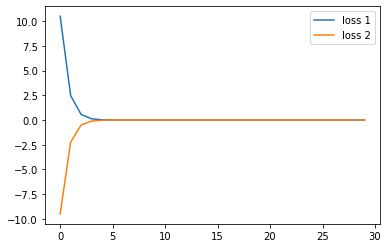

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(30), l1, label="loss 1")
plt.plot(range(30), l2, label="loss 2")
plt.legend()